# Assignment 2

## Reader Guide

- **Author**: Noah Bakayou  
- **Data Source**: In project root create a data folder. Include the `bus.csv`, `ins.csv`, `ins2vio.csv` and `vio.csv`
- **Source folder**: Create a `src` folder in project root where ipynb will live.
- **Environment**: pip install using the included requirements.txt 


# Part 0 - Imports and CoW

In [1085]:
# Enforce Copy-on-Write
import pandas as pd
pd.set_option("mode.copy_on_write", True)

In [1086]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Part 1 - Regex, EDA, and Visualization

Load the Food Safety datasets (bus.csv, ins2vio.csv, ins.csv, and vio.csv) into pandas dataframes and answer the following questions based on the dataframes.

In [ ]:
#Load the datasets into Pandas DataFrames
from pathlib import Path

cwd = Path().cwd() # should be our src folder, containing this notebook
project_folder = cwd.parent #should be our project folder, containing the src folder
bus_dataset_path     = Path('data/bus.csv') # using a data folder makes life easier
ins_dataset_path     = Path('data/ins.csv')
ins2vio_dataset_path = Path('data/ins2vio.csv')
vio_dataset_path     = Path('data/vio.csv')

bus_file      = project_folder / bus_dataset_path  
ins_file      = project_folder / ins_dataset_path    
ins2vio_file  = project_folder / ins2vio_dataset_path
vio_file      = project_folder / vio_dataset_path    

if not bus_file.exists() or not ins_file.exists() or not ins2vio_file.exists() or not vio_file.exists():
    raise FileNotFoundError(f"Dataset file not found: {bus_file} or {ins_file} or {ins2vio_file} or {vio_file}")

bus = pd.read_csv(bus_file)
ins = pd.read_csv(ins_file)
ins2vio = pd.read_csv(ins2vio_file)
vio = pd.read_csv(vio_file)

display(bus.head())
display(ins.head())
display(ins2vio.head())
display(vio.head())


,business id column,name,address,city,state,postal_code,latitude,longitude,phone_number
0,1000,HEUNG YUEN RESTAURANT,3279 22nd St,San Francisco,CA,94110,37.755282,-122.420493,-9999
1,100010,ILLY CAFFE SF_PIER 39,PIER 39 K-106-B,San Francisco,CA,94133,-9999.000000,-9999.000000,14154827284
2,100017,AMICI'S EAST COAST PIZZERIA,475 06th St,San Francisco,CA,94103,-9999.000000,-9999.000000,14155279839
3,100026,LOCAL CATERING,1566 CARROLL AVE,San Francisco,CA,94124,-9999.000000,-9999.000000,14155860315
4,100030,OUI OUI! MACARON,2200 JERROLD AVE STE C,San Francisco,CA,94124,-9999.000000,-9999.000000,14159702675


,iid,date,score,type
0,100010_20190329,03/29/2019 12:00:00 AM,-1,New Construction
1,100010_20190403,04/03/2019 12:00:00 AM,100,Routine - Unscheduled
2,100017_20190417,04/17/2019 12:00:00 AM,-1,New Ownership
3,100017_20190816,08/16/2019 12:00:00 AM,91,Routine - Unscheduled
4,100017_20190826,08/26/2019 12:00:00 AM,-1,Reinspection/Followup


,iid,vid
0,97975_20190725,103124
1,85986_20161011,103114
2,95754_20190327,103124
3,77005_20170429,103120
4,4794_20181030,103138


,description,risk_category,vid
0,Consumer advisory not provided for raw or unde...,Moderate Risk,103128
1,Contaminated or adulterated food,High Risk,103108
2,Discharge from employee nose mouth or eye,Moderate Risk,103117
3,Employee eating or smoking,Moderate Risk,103118
4,Food in poor condition,Moderate Risk,103123


Use the business dataset (bus) to answer the first few questions below

1.1) Examining the entries in `bus`, is the `bid` unique for each record (i.e. each row of data)?

Hint: use `value_counts()` or `unique()` to determine if the `bid` series has any duplicates.

In [ ]:
bid = bus['business id column']
bid_counts = pd.Series(bid).value_counts()
#print(bid_counts)

duplicate_bids = bid_counts > 1 #Returns a boolean series of t/f for each bid
if duplicate_bids.any() == True:
    print("The 'bid' column is not unique for each record.")
else:
    print("The 'bid' column is unique for each record.")


The 'bid' column is unique for each record.


1.2) In the two cells below create the following **two numpy arrays**:

1. Assign `top_names` to the top 5 most frequently used business names, from most frequent to least frequent.
2. Assign `top_addresses` to the top 5 addressses where businesses are located, from most popular to least popular.

Hint: you may find `value_counts()` helpful. 

In [1089]:
bus.head()
bus_top_names = bus['name'].value_counts().head(5)
bus_top_addresses = bus['address'].value_counts().head(5)

print(bus_top_names)
print(bus_top_addresses)


name
Peet's Coffee & Tea    20
Starbucks Coffee       13
McDonald's             10
Jamba Juice            10
STARBUCKS               9
Name: count, dtype: int64
address
Off The Grid      39
428 11th St       34
2948 Folsom St    17
3251 20th Ave     17
Pier 41           16
Name: count, dtype: int64


1.3) Look at the businesses that DO NOT have the special MISSING ZIP code value. Some of the invalid postal codes are just the full 9 digit code rather than the first 5 digits. Create a new column named `postal5` in the original bus dataframe which contains only the first 5 digits of the postal_code column. Finally, for any of the likely MISSING postal5 ZIP code entries set the entry to None.

In [ ]:
# Get rows where pattern does NOT match
bad_postal_codes = bus[bus['postal_code'].astype(str).str.match(r'^\d{5}$') == False]['postal_code']

# Examine the bad postal codes
# for bad_code in bad_postal_codes:
#     print(bad_code)

#get first 5 digits of postal_code
bus['postal5'] = bus['postal_code'].astype(str).str[:5]

# Set missing values to None:
#   - Only keep codes starting with 94. There were some codes starting with 64, 95, 92, 00000, -9999, CA...
#   - Noticed dataset had mainly 94 codes and after googling, I realized that only codes starting with 94 
#    are valid area codes for San Francisco.
valid_data = bus['postal5'].str.match(r'^94\d{3}$')
bus.loc[valid_data == False, 'postal5'] = None

#check
print(bus['postal5'].unique())

['94110' '94133' '94103' '94124' '94123' '94118' '94121' '94134' '94114'
 '94109' '94102' '94132' '94116' None '94107' '94105' '94108' '94117'
 '94158' '94112' '94127' '94111' '94122' '94115' '94104' '94131' '94518'
 '94013' '94130' '94120' '94143' '94101' '94014' '94129' '94602' '94080'
 '94188' '94544' '94301' '94901' '94621']


Now using the four Food Safety datasets bus.csv, ins2vio.csv, ins.csv, and vio.csv:

1.5) Create a side-by-side boxplot that shows the distribution of the restaurant scores for each different risk category from 2017 to 2019. Use a figure size of at least 12 by 8.

Hint: Consider using appropriate JOIN operations.

/var/folders/2j/_9j01ry54m79wdlx_7m_jwcw0000gn/T/ipykernel_70110/976338628.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ins['date_dt'] = pd.to_datetime(ins['date'])


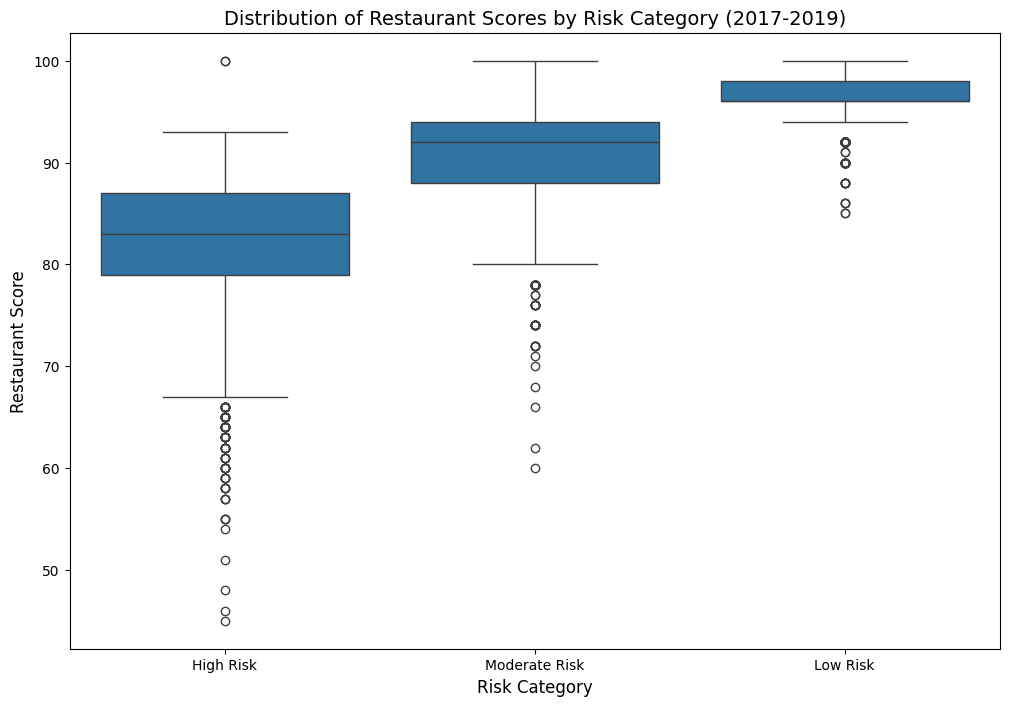

In [ ]:
ins['date_dt'] = pd.to_datetime(ins['date'])
ins['year'] = ins['date_dt'].dt.year

# Filter data only 2017-2019 and valid scores that are not -1
ins_clean = ins[(ins['year'] >= 2017) & (ins['year'] <= 2019) & (ins['score'] > 0)]

# join tables to connect inspections with risk categories
data = ins_clean.merge(ins2vio, on='iid', how='inner')

# then add violation info to get risk categories
data = data.merge(vio, on='vid', how='inner')

# Problem: I noticed one inspection can have multiple violations with differing risk categories
# My solution is to only keep the highest risk violation per inspection since the worst 
# inspection they got is a better represntation of the data.

data['risk_priority'] = 0
data.loc[data['risk_category'] == 'Low Risk', 'risk_priority'] = 1
data.loc[data['risk_category'] == 'Moderate Risk', 'risk_priority'] = 2
data.loc[data['risk_category'] == 'High Risk', 'risk_priority'] = 3

# Sort by highest first and only keep highest risk violation for each inspection
data_sorted = data.sort_values('risk_priority', ascending=False)
data_unique = data_sorted.drop_duplicates(subset='iid', keep='first')

plt.figure(figsize=(12, 8))
sns.boxplot(data=data_unique, x='risk_category', y='score')
plt.xlabel('Risk Category', fontsize=12)
plt.ylabel('Restaurant Score', fontsize=12)
plt.title('Distribution of Restaurant Scores by Risk Category (2017-2019)', fontsize=14)
plt.show()


# Part II - Making a Synthetic Dataset

In this part you're going to be create a synthetic dataset (dataframe) with 1000 observations (rows). You are going to use random number generators to create the data for you.

You can use either the numpy or scipy library, whichever you find easier. Be sure to import any libraries you use at the top of the ntoebook (not down here).

In [1092]:
n = 10000

In [1093]:
np.random.seed(123)


2.1) Create a variable "v1" of 10,000 numbers where y = 3x+4 is the value of the element at index x, i.e., [4, 7, 10, ...] (Done for you)

In [1094]:
v1 = 3 * np.arange(n) + 4

2.2) Create a list of 10,000 samples from a normal (Gaussian) distribution with mean = 0 and variance = 10.

HINT: Pay attention to whether the argument to your number generator is variance or standard deviation. (It doesn't have to be a python list, it can be an array or dataframe, or whatever dtype is most convenient for you.)

In [1095]:
noise = np.random.normal(0, np.sqrt(10), n)
print(noise)

[-3.4330654   3.15388323  0.89485658 ... -1.49343753  1.84033291
  3.06934737]


2.3) Create a variable v2 = v1 + Gaussian noise, using the noise your created above

In [1096]:
v2 = v1 + noise
print(v2[:10])

[ 0.5669346  10.15388323 10.89485658  8.23667788 14.17030535 24.22230087
 14.32616644 23.64365918 32.00324195 28.25912619]


2.4) Create a variable v3 = exp(v1) that exponentiates the libear variable in v1, also sometimes denoted e^(v1), e.g., v3[0] = e^4

In [1097]:
v3 = np.exp(v1)
print(v3[:5])

[5.45981500e+01 1.09663316e+03 2.20264658e+04 4.42413392e+05
 8.88611052e+06]


/var/folders/2j/_9j01ry54m79wdlx_7m_jwcw0000gn/T/ipykernel_70110/996647468.py:1: RuntimeWarning: overflow encountered in exp
  v3 = np.exp(v1)


2.5) Create a list v4 = exp(v1) + Gaussian noise, using the same noise variable you created earlier

In [1098]:
v4 = np.exp(v1) + noise
print(v4[:5])

[5.11650846e+01 1.09978704e+03 2.20273607e+04 4.42408629e+05
 8.88610869e+06]


/var/folders/2j/_9j01ry54m79wdlx_7m_jwcw0000gn/T/ipykernel_70110/510129836.py:1: RuntimeWarning: overflow encountered in exp
  v4 = np.exp(v1) + noise


2.6) Create a list v5 = exp(v1 + Gaussian noise), using the same noise variable you created earlier

In [1099]:
v5 = np.exp(v1 + noise)
print(v5[:5]) 

[1.76285490e+00 2.56906714e+04 5.38984275e+04 3.77697188e+03
 1.42588802e+06]


/var/folders/2j/_9j01ry54m79wdlx_7m_jwcw0000gn/T/ipykernel_70110/3038603174.py:1: RuntimeWarning: overflow encountered in exp
  v5 = np.exp(v1 + noise)


2.7) Create a dataframe with 10,000 rows and columns = [v1, v2, v3, v4, v5, noise]

In [1100]:
my_df = pd.DataFrame({
    'v1': v1,
    'v2': v2,
    'v3': v3,
    'v4': v4,
    'v5': v5,
    'noise': noise
})

print(my_df.head())

   v1         v2            v3            v4            v5     noise
0   4   0.566935  5.459815e+01  5.116508e+01  1.762855e+00 -3.433065
1   7  10.153883  1.096633e+03  1.099787e+03  2.569067e+04  3.153883
2  10  10.894857  2.202647e+04  2.202736e+04  5.389843e+04  0.894857
3  13   8.236678  4.424134e+05  4.424086e+05  3.776972e+03 -4.763322
4  16  14.170305  8.886111e+06  8.886109e+06  1.425888e+06 -1.829695


2.8) For each variable (v2, v3, v4, v5) create a separate scatter plot with v1 on the x-axis. Remark on your general observations.

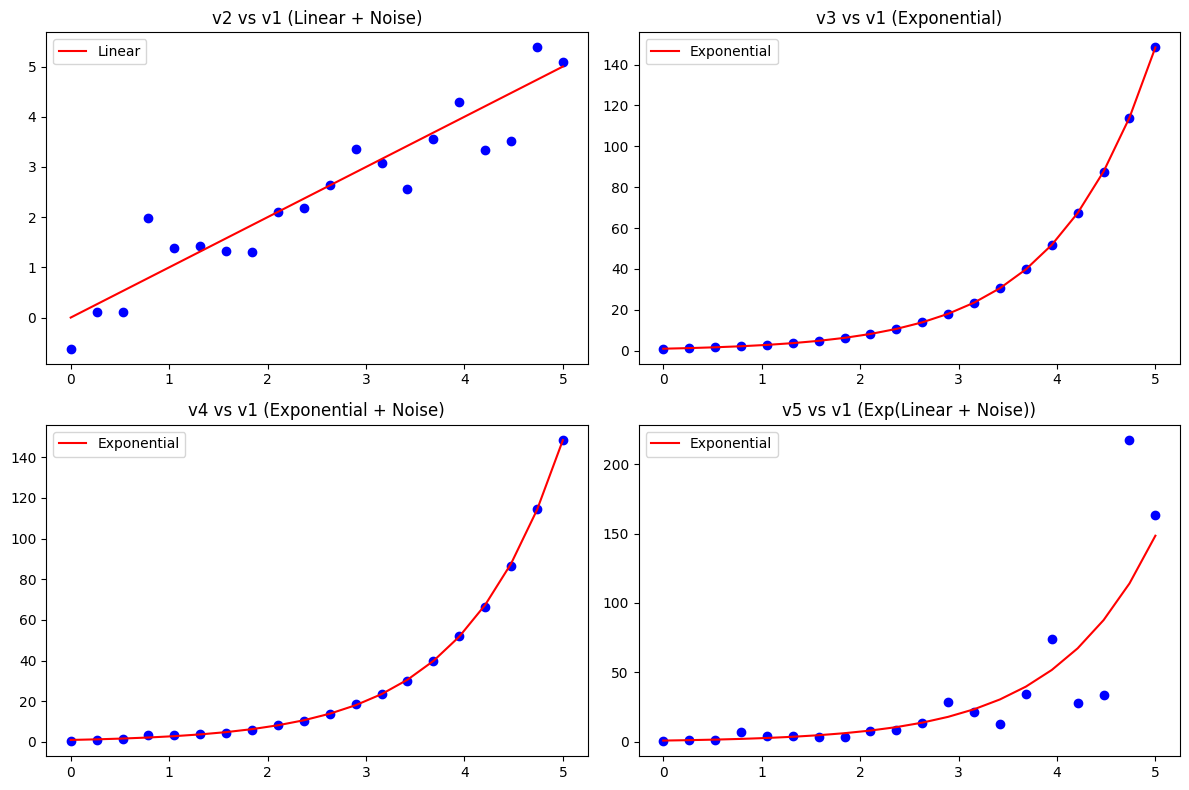

' \nGraph 1: The graph follows a linear line with points scattered above, on, and below the line of best fit. But it follows the linear upward trajectory.\nGraph 2: The graph follows the exponential curve as expected. Each point is exactly on the exponential curve.\nGraph 3: The graph follows the exponential curve, but the points are scattered above and below the exponential curve.\nGraph 4 (most interesting one): The graph follows the exponential curve as expected. Additionally, the exponential curve in v5 looks less smooth and more variable than in the other exponential graphs, because the noise is amplified by the exponential function.\nThis is due to the exponential causing some points to be much higher and lower.\n'

In [ ]:
# Tried using original values we had, but we need to use a small v1 values since exp(v1)
#  grows very quickly...and this will make the graph easier to interpret.
v1_small = np.linspace(0, 5, 20) # spread out the values of v1 to make the graph easier to interpret
noise_small = np.random.normal(0, 0.5, len(v1_small))
v2_small = v1_small + noise_small
v3_small = np.exp(v1_small)
v4_small = np.exp(v1_small) + noise_small
v5_small = np.exp(v1_small + noise_small)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

#graph 1: v2 vs v1 linear + noise
axes[0, 0].scatter(v1_small, v2_small, color='b')
axes[0, 0].plot(v1_small, v1_small, 'r-', label='Linear')
axes[0, 0].set_title('v2 vs v1 (Linear + Noise)')
axes[0, 0].legend()

#graph 2: v3 vs v1 Exponential
axes[0, 1].scatter(v1_small, v3_small, color='b')
axes[0, 1].plot(v1_small, np.exp(v1_small), 'r-', label='Exponential')
axes[0, 1].set_title('v3 vs v1 (Exponential)')
axes[0, 1].legend()

#graph 3: v4 vs v1 eponential + noise
axes[1, 0].scatter(v1_small, v4_small, color='b')
axes[1, 0].plot(v1_small, np.exp(v1_small), 'r-', label='Exponential')
axes[1, 0].set_title('v4 vs v1 (Exponential + Noise)')
axes[1, 0].legend()

#graph 4: v5 vs v1 exp(linear + noise)
axes[1, 1].scatter(v1_small, v5_small, color='b')
axes[1, 1].plot(v1_small, np.exp(v1_small), 'r-', label='Exponential')
axes[1, 1].set_title('v5 vs v1 (Exp(Linear + Noise))')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

""" 
Graph 1: The graph follows a linear line with points scattered above, on, and below 
the line of best fit. But it follows the linear upward trajectory.

Graph 2: The graph follows the exponential curve as expected. 
Each point is exactly on the exponential curve.

Graph 3: The graph follows the exponential curve, 
but the points are scattered above and below the exponential curve.

Graph 4 (most interesting one): The graph follows the exponential curve as expected. 
Additionally, the exponential curve in v5 looks less smooth and more variable than in the other exponential graphs, 
because the noise is amplified by the exponential function.
This is due to the exponential causing some points to be much higher and lower.
"""

2.9)  Create pair of boxplots with v4 and v5 next to each other. Remark on how v4 and v5 compare, based on the violin plots and the scatter plots. You may use other plots or tools if helpful.

/var/folders/2j/_9j01ry54m79wdlx_7m_jwcw0000gn/T/ipykernel_70110/3646691992.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


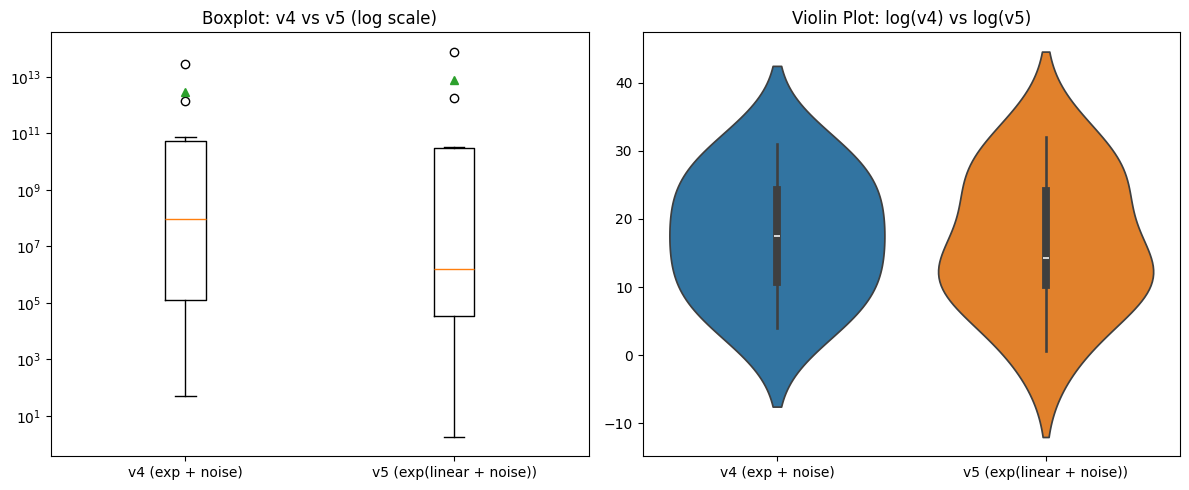

'\nIn order to really get a sense of the difference between v4 and v5, I used a log scale for the boxplot and violin plot. \nBecause the exponential grows very fast, log scale helps compress the y-axis so we can see both large and small values on the same plot, and it better represents the spread of the data and the median.\n\nI noticed a couple things from the plots:\n - In v4, the data is more tightly clustered and the distribution is symmetric and not very spread out. There are outliers, but most of the data is around the center.\n - In v5, the values are much more spread out due to the exponential acting on the noise, causing more extreme values and a fatter tail. (This was really interesting to see)\n\nFrom these findings in the box and violin plots, we can see that v5 has much greater spread and variability. Adding noise before exponentiation creates a messier and more extreme distribution, while adding noise after exponentiation creates a more symmetric and tightly clustered dis

In [ ]:

# Use a very small slice for visualization. Exponetial grows fast
v4_plot = v4[:10]
v5_plot = v5[:10]
data = [v4_plot, v5_plot]
labels = ['v4 (exp + noise)', 'v5 (exp(linear + noise))']

plt.figure(figsize=(12, 5))

# Boxplot using log scale
plt.subplot(1, 2, 1)
plt.boxplot(data, labels=labels, showmeans=True)
plt.yscale('log')
plt.title('Boxplot: v4 vs v5 (log scale)')

# Violin plot using loc scale
plt.subplot(1, 2, 2)
sns.violinplot(data=[np.log(v4_plot), np.log(v5_plot)])
plt.xticks([0, 1], labels)
plt.title('Violin Plot: log(v4) vs log(v5)')

plt.tight_layout()
plt.show()

"""
In order to really get a sense of the difference between v4 and v5, 
I used a log scale for the boxplot and violin plot. 

Because the exponential grows very fast, log scale helps compress the y-axis 
so we can see both large and small values on the same plot, and it better 
represents the spread of the data and the median.

I noticed a couple things from the plots:
 - In v4, the data is more tightly clustered and the distribution is symmetric and not very spread out. 
   There are outliers, but most of the data is around the center.

 - In v5, the values are much more spread out due to the exponential acting on the noise, 
   causing more extreme values and a fatter tail. (This was really interesting to see)

From these findings in the box and violin plots, we can see that v5 has much greater spread and variability.
 Adding noise before exponentiation creates a messier and more extreme distribution, 
 while adding noise after exponentiation creates a more symmetric and tightly clustered distribution.

"""

## Part III - Sampling and Convergence

3.1) Create a variable "pareto" that is a list of 10,000 samples from a Pareto distribution with shape parameter = 1.2 (usually denoted a or alpha). Add this list "pareto" as a column to your dataframe from Part II

In [1103]:
pareto = np.random.pareto(a=1.2, size=10000)

my_df['pareto'] = pareto
print(my_df[['pareto']].head())

     pareto
0  0.399263
1  2.606559
2  0.674959
3  0.206429
4  0.459572


3.2) Add two more columns to your dataframe labeled "running_avg_normal" and "running_avg_pareto". In the "running_avg_normal" column put the running average of the (unsorted) values in the noise column. For example, if the values in the noise column are [0.1, 0.3, 0.5, ...] then the running average should be [0.1, 0.2, 0.3, ...]. Do the same for the Pareto column.

HINT: Check out the .expanding() and .mean() methods for pandas Series objects

In [1104]:
my_df['running_avg_normal'] = my_df['noise'].expanding().mean()
my_df['running_avg_pareto'] = my_df['pareto'].expanding().mean()

print(my_df[['running_avg_normal', 'running_avg_pareto']].head(10))

   running_avg_normal  running_avg_pareto
0           -3.433065            0.399263
1           -0.139591            1.502911
2            0.205225            1.226927
3           -1.036912            0.971802
4           -1.195468            0.869356
5           -0.125840            0.948264
6           -1.204125            1.052040
7           -1.223152            1.008853
8           -0.642442            0.907983
9           -0.852285            0.849489


3.3) Create a lineplot for running_avg_normal and a lineplot for running_avg_Pareto. Remark on your observations.

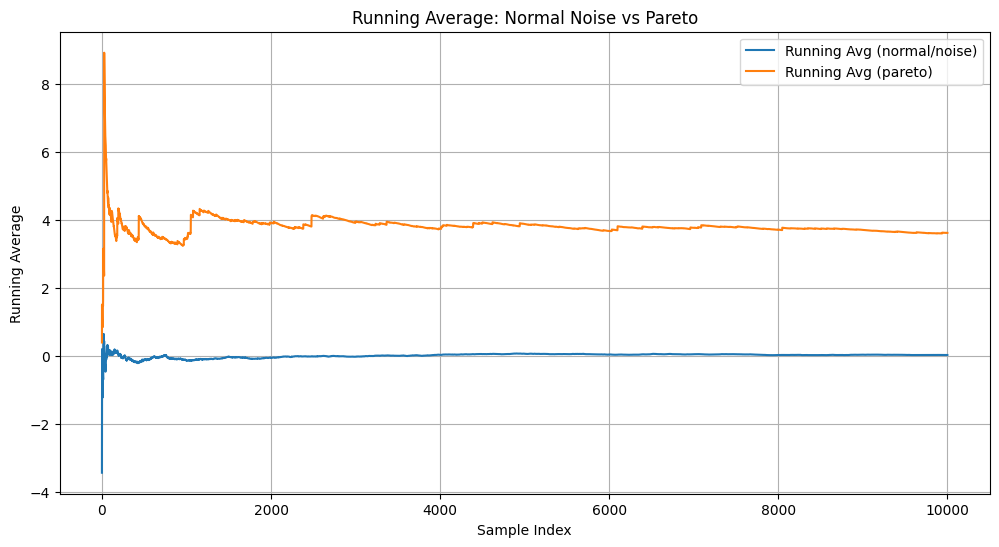

"\nThis was a really interestnig plot and showed me a few things. First I noticed that the running average of the normal noise (blue) quickly settled near 0 and stays there. \nI expected this because the normal distributino is centered at 0. \n\nThe pareto distribution is a little more interesting(orange). It's much more spkikey early on and changes since we will get many small values and then occasionally a few very large outliers. \nOver time, we can that it does begin to settle toward the middle value however it has much more jumps you can see from the spikes throughout the line. \n\nThis shows that averages from normal noise stabilize quickly, however averages from these heavy tailed distributions like pareto are more sensitive to outliers and it takes much longer to converge. \n\n"

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(my_df['running_avg_normal'], label='Running Avg (normal/noise)')
plt.plot(my_df['running_avg_pareto'], label='Running Avg (pareto)')
plt.xlabel('Sample Index')
plt.ylabel('Running Average')
plt.title('Running Average: Normal Noise vs Pareto')
plt.legend()
plt.grid()
plt.show()

"""
This was a really interestnig plot and showed me a few things. 
First I noticed that the running average of the normal noise (blue) quickly settled near 0 and stays there. 
I expected this because the normal distributino is centered at 0. 

The pareto distribution is more interesting(orange). 
It's much more spkikey early on and changes since we will get many small values and 
then occasionally a few very large outliers. 
Over time, we can that it does begin to settle toward the middle value,
however it has much more jumps you can see from the spikes throughout the line. 

I noticed that the pareto distribution is very similar to how wealth is distributed in the world. 
Most people are average and we have a few very rich people that pull up the average wealth by a lot. 
Now I know the true impact of dealing with data in extrimistan. 

This shows that averages from normal noise stabilize quickly, 
however averages from these heavy tailed distributions 
like pareto are more sensitive to outliers and it takes much longer to converge. 

"""